# Strategy

In this notebook, we attempt to train an inverse dynamics model (IDM). In Reinforcement Learning parlance, an IDM learns to predict $a_t$ given $s_t$ and $s_{t+1}$. In our case, we have access to the MetaDrive simulator and the Waymo dataset. We want to predict the action the car should take in MetaDrive so that the successor state in the simulator is as close as possible to the successor state in the Waymo dataset.

In [1]:
%load_ext autoreload
%autoreload 2

import env
import loader_utils
import waymo_loader
import pickle
import os
import lzma
import numpy as np
import random
import gymnasium as gym
import typing
from metadrive import MetaDriveEnv

from env import State, Observation, Action, state_batch_to_tensor, action_batch_to_tensor, obs_batch_to_tensor, get_metadrive_state, next_state, normalize_angle
from metadrive_model import MetadriveModel
from model_utils import set_lr, deviceof

# CHANGE ME: Set this to the path to the Waymo Open Dataset root directory
WAYMO_DATA_PATH = "~/data/waymo"

Successfully registered the following environments: ['MetaDrive-validation-v0', 'MetaDrive-10env-v0', 'MetaDrive-100envs-v0', 'MetaDrive-1000envs-v0', 'SafeMetaDrive-validation-v0', 'SafeMetaDrive-10env-v0', 'SafeMetaDrive-100envs-v0', 'SafeMetaDrive-1000envs-v0', 'MARLTollgate-v0', 'MARLBottleneck-v0', 'MARLRoundabout-v0', 'MARLIntersection-v0', 'MARLParkingLot-v0', 'MARLMetaDrive-v0'].


2023-08-26 21:34:18.676728: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-26 21:34:19.747264: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/fidgetsinner/venvs/metadrive/lib/python3.11/site-packages/tensorflow/python/debug/cli/debugger_cli_common.py:19: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants


In [8]:
file_iter = iter(loader_utils.getFiles(WAYMO_DATA_PATH))
trajectories: list[list[State]] = []

In [34]:
for file_path in file_iter:
    trajectories_in_file = waymo_loader.parse_file(file_path)
    trajectories.extend(trajectories_in_file)
    print(f"Loaded {len(trajectories_in_file)} trajectories from {file_path}.")

Loaded 88 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00040-of-01000.
Loaded 68 trajectories from /home/fidgetsinner/data/waymo/training_20s.tfrecord-00041-of-01000.


KeyboardInterrupt: 

In [36]:
# pickle the trajectories
if not os.path.exists('./data/waymo/trajectories.pkl.xz'):
    with lzma.open('./data/waymo/trajectories.pkl.xz', 'wb') as f:
        pickle.dump(trajectories, f)

In [2]:
# unpickle and decompress
if "trajectories" not in locals():
    with lzma.open('./data/waymo/trajectories.pkl.xz', 'rb') as f:
        trajectories: list[list[State]] = pickle.load(f)

In [3]:
idm_data: list[Observation] = []
for states in trajectories:
    for i in range(len(states)-1):
        idm_data.append((states[i], states[i+1]))

# 90:10 train-validation split
random.seed(0)
random.shuffle(idm_data)
idm_train_data = idm_data[:int(len(idm_data)*0.9)]
idm_validation_data = idm_data[int(len(idm_data)*0.9):]

In [4]:
print("train data:", len(idm_train_data))
print("validation data:", len(idm_validation_data))

train data: 419886
validation data: 46654


In [5]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
mm = MetadriveModel().to(device)
mm.load_state_dict(torch.load('data/mm.pth'))

<All keys matched successfully>

Now that we have trained a neural network model of Metadrive through which we can backprop, training the IDM is easy.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# creates a model that attempts to predict the action given the current state and the next state
class InverseDynamicsModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 4, 2)
        # output shape: (batch_size, 2)

        self.conv1 = nn.Conv1d(4, 768, 2) # Bx4x2 -> Bx768x1
        self.fc1 = nn.Linear(768, 768) # Bx768 -> Bx768
        self.fc2 = nn.Linear(768, 2) # Bx768 -> Bx2
    
    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x)) # Bx4x2 -> Bx768x1
        x = torch.flatten(x, 1) # Bx768x1 -> Bx768
        x = F.relu(self.fc1(x)) # Bx768 -> Bx768
        x = self.fc2(x) # Bx768 -> Bx2
        return x

def idm_train_batch(
        mm: MetadriveModel,
        idm: InverseDynamicsModel,
        idm_optimizer: torch.optim.Optimizer,
        obs_batch: list[Observation],
) -> float:
    device = deviceof(mm)

    assert deviceof(idm) == device

    obs_tensor = obs_batch_to_tensor(obs_batch, device)
    s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
    s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)

    idm_optimizer.zero_grad()

    pred_action = idm(obs_tensor)
    pred_s1 = mm(s0_tensor, pred_action)

    loss = F.mse_loss(pred_s1, s1_tensor)
    loss.backward()

    idm_optimizer.step()

    return float(loss.item())

In [8]:
import itertools

idm_train_iter = itertools.cycle(idm_train_data)

idm = InverseDynamicsModel().to(device)

idm_optimizer = torch.optim.AdamW(idm.parameters())

idm_step = 0
idm_losses = []

In [12]:
set_lr(idm_optimizer, 3e-5)
INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS = 10000
INVERSE_DYNAMICS_MODEL_TRAIN_BATCH_SIZE = 4096

while idm_step < INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS:
    obs_batch = [next(idm_train_iter) for _ in range(INVERSE_DYNAMICS_MODEL_TRAIN_BATCH_SIZE)]
    loss = idm_train_batch(
        mm,
        idm,
        idm_optimizer,
        obs_batch,
    )
    idm_losses.append(loss)
    idm_step += 1
    if idm_step % 500 == 0:
        # print average loss over last 500 steps
        loss = np.mean(idm_losses[-500:])
        print(f"Step: {idm_step}, Loss: {loss:.5f}")

Step: 3500, Loss: 0.00096
Step: 4000, Loss: 0.00080
Step: 4500, Loss: 0.00076
Step: 5000, Loss: 0.00070
Step: 5500, Loss: 0.00067


KeyboardInterrupt: 

In [9]:
# load idm
if 'idm' not in locals():
    idm = InverseDynamicsModel().to(device)
    idm.load_state_dict(torch.load('waymo_data/idm.pth'))    

In [19]:
# save idm
if not os.path.exists('./data/waymo/idm.pth'):
    torch.save(idm.state_dict(), './data/waymo/idm.pth')

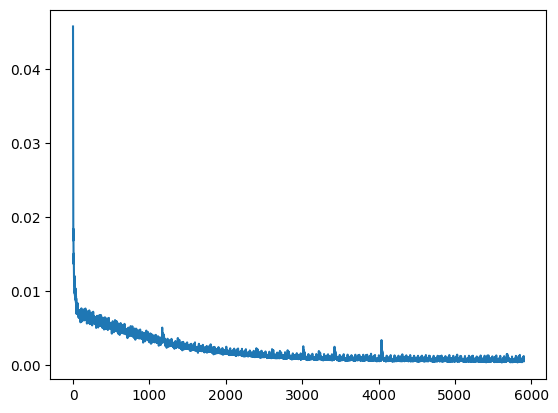

In [13]:
import matplotlib.pyplot as plt

# Plot the losses over training
plt.plot(list(range(len(idm_losses))), idm_losses, label='IDM')
plt.show()

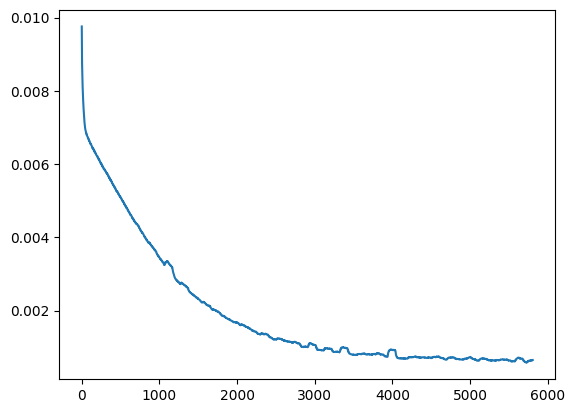

In [14]:
# compute running average of the last 200 episodes
# plot the average reward per episode
idm_losses_averaged = np.convolve(idm_losses, np.ones((100,))/100, mode='valid')
plt.plot(idm_losses_averaged)

Let' compare our trained IDM against the null idm (predicts 0 for all values):

In [34]:
obs_batch = idm_train_data

obs_tensor = obs_batch_to_tensor(obs_batch, device)
s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)
with torch.no_grad():
    action_pred = idm(obs_tensor)
    s1_pred = mm(s0_tensor, action_pred)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].cpu().detach().numpy()
loss_y = loss[:, 1].cpu().detach().numpy()
loss_theta = loss[:, 2].cpu().detach().numpy()

print("training loss", loss.mean().item())

training loss 0.0005964423762634397


In [27]:
obs_batch = idm_validation_data

obs_tensor = obs_batch_to_tensor(obs_batch, device)
s0_tensor = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
s1_tensor = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)
with torch.no_grad():
    action_pred = idm(obs_tensor)
    s1_pred = mm(s0_tensor, action_pred)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].cpu().detach().numpy()
loss_y = loss[:, 1].cpu().detach().numpy()
loss_theta = loss[:, 2].cpu().detach().numpy()

print("validation loss", loss.mean().item())

validation loss 0.0005954874213784933


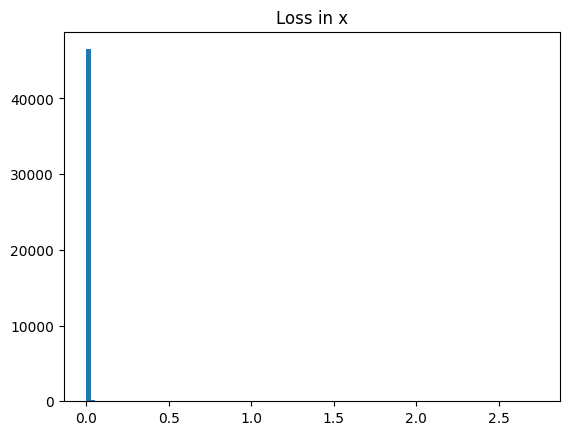

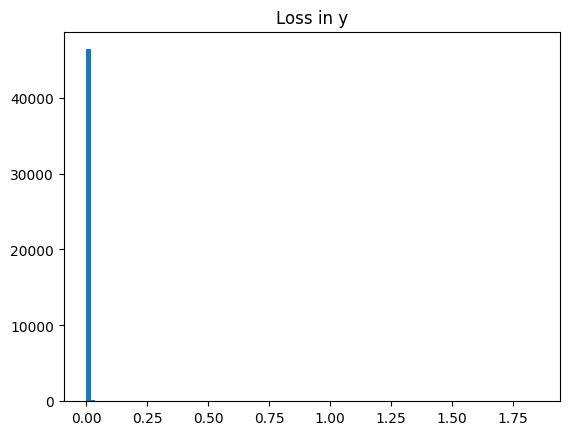

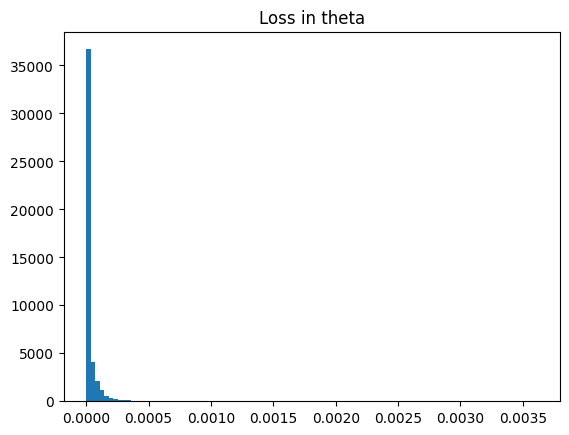

In [28]:
plt.hist(loss_x, bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y, bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta, bins=100)
plt.title('Loss in theta')
plt.show()


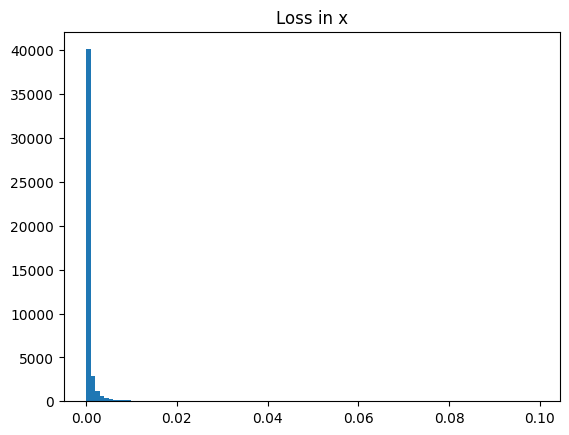

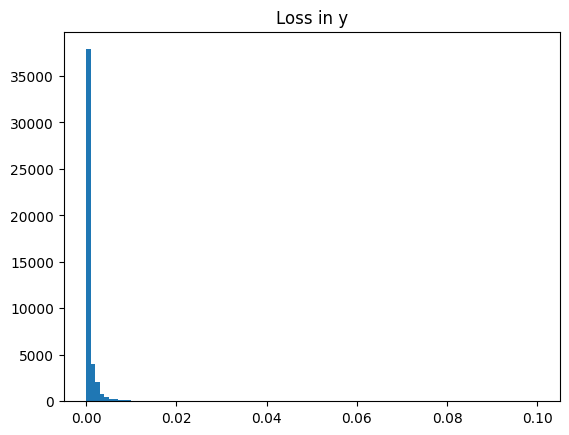

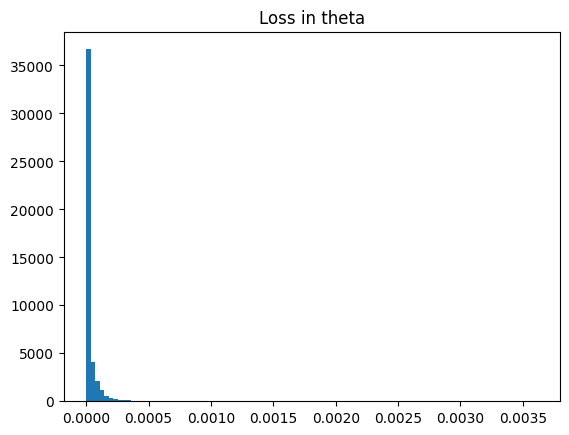

In [29]:
loss_x_no_outliers = np.array([x for x in loss_x if x < 0.1 ]) 
loss_y_no_outliers = np.array([x for x in loss_y if x < 0.1 ])
loss_theta_no_outliers = np.array([x for x in loss_theta if x < 0.1 ])

plt.hist(loss_x_no_outliers, bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y_no_outliers, bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta_no_outliers, bins=100)
plt.title('Loss in theta')
plt.show()


Let's try visualizing our IDM by having it follow a track from start to finish.

In [30]:
class IDMPolicy:
    def __init__(self, net: InverseDynamicsModel):
        self.net = net

    def __call__(self, obs:Observation) -> Action:
        # sample an action from the policy network
        obs_tensor = obs_batch_to_tensor([obs], deviceof(self.net))
        # sample an action from the policy network
        with torch.no_grad():
            steering, throttle = self.net(obs_tensor)[0]
        return steering.item(), throttle.item()


In [39]:
env = gym.make("MetaDrive-validation-v0", config={"on_continuous_line_done": False, "use_render": True})

### Trajectory Replay

In [44]:
scenario = trajectories[2]

# reset
env.reset()

# allow car to settle
for _ in range(10):
    env.step([0,0])

# set the initial state
for i in range(len(scenario)):
    st = scenario[i]
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)
    env.step([0, 0])        

INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.
INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.
INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.
INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.
INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.
INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.
INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.
INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.
INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/

### Closed Loop IDM

In [45]:
with torch.no_grad():
    # reset
    env.reset()

    # allow car to settle
    for _ in range(10):
        env.step([0,0])

    st = scenario[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(scenario)-1):
        st0 = scenario[i]
        st1 = scenario[i+1]
        st0_pred = get_metadrive_state(env)
        action = IDMPolicy(idm)((st0_pred, st1))
        env.step(action)
        st1_pred = get_metadrive_state(env)
        print(action)
        print(st1_pred.velocity, st1_pred.heading, st1.velocity, st1.heading)
        

(-0.12578174471855164, -0.005814487114548683)
[ 4.68303275e-04 -5.29825411e-06] 2.7080219054835686 [-1.5612082e-04  1.2055355e-06] 2.7080225944519043
(-0.12550346553325653, -0.005761537700891495)
[ 0.00208126 -0.00096251] 2.7080229707480044 [ 7.0465088e-05 -4.2924524e-04] 2.7080166339874268
(-0.12583360075950623, -0.004632055759429932)
[-1.09578599e-04  8.51851364e-05] 2.7080232370641135 [4.908281e-04 7.887598e-05] 2.708031415939331
(-0.1257455199956894, -0.006069079041481018)
[ 0.00090094 -0.00047398] 2.7080232370641135 [-8.0136160e-05  1.0077404e-04] 2.7080202102661133
(-0.1254970133304596, -0.005239339545369148)
[-0.00084696  0.00043001] 2.7080225712738413 [-3.2553275e-05 -3.1884658e-04] 2.708024501800537
(-0.12576687335968018, -0.00695713609457016)
[ 0.00114694 -0.00061454] 2.708023636538277 [1.5774927e-04 1.0086335e-05] 2.7080235481262207
(-0.12610580027103424, -0.004789600148797035)
[-0.00089607  0.00046083] 2.708023636538277 [-0.00016204  0.00085328] 2.708029270172119
(-0.125911

INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.22102652490139008, 0.5533127188682556)
[-3.94566703  0.55293387] 2.9162663221837146 [-3.9781797   0.56195384] 2.9307169914245605


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1983179748058319, 0.49397844076156616)
[-4.09029675  0.50575995] 2.9401157286937014 [-4.1047935  0.5138477] 2.9514620304107666


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.23684318363666534, 0.45103079080581665)
[-4.22222567  0.37173501] 2.9644740652880026 [-4.226667    0.41474977] 2.973093271255493


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2243097573518753, 0.4345211982727051)
[-4.34830952  0.27384549] 2.9912895674620645 [-4.3457804  0.3102833] 2.9957497119903564


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2278154045343399, 0.4120083451271057)
[-4.46521902  0.15552014] 3.018729181437587 [-4.4564486   0.20236585] 3.0202691555023193


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.24927635490894318, 0.37659281492233276)
[-4.56516647 -0.00519275] 3.0476768103803664 [-4.544708    0.05861813] 3.046781539916992


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.22136704623699188, 0.33246028423309326)
[-4.65659189 -0.10931154] 3.077946432488262 [-4.612304   -0.06720607] 3.0738799571990967


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.22242315113544464, 0.2966070771217346)
[-4.7317214  -0.24315542] 3.107304188238914 [-4.6756377 -0.1884329] 3.1015937328338623


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.22561527788639069, 0.2656940817832947)
[-4.79230213 -0.39247254] 3.136896834797711 [-4.7285433  -0.32951534] 3.1303560733795166


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2212647944688797, 0.2547639012336731)
[-4.84694386 -0.53811812] -3.1162466837052367 [-4.782381  -0.4741504] -3.123082399368286


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2378346174955368, 0.2486657351255417)
[-4.88659859 -0.72117287] -3.085513671567668 [-4.83188    -0.64095175] -3.092775583267212


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.23537294566631317, 0.2539837956428528)
[-4.92646456 -0.89093363] -3.0532830307910928 [-4.8817987 -0.8193783] -3.061445474624634


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2327975630760193, -0.08661419153213501)
[-4.75626612 -1.01739383] -3.0207945960209983 [-4.6906514 -0.9433318] -3.0280251502990723


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.24268360435962677, 0.21607713401317596)
[-4.77134228 -1.19593215] -2.988609894773227 [-4.7210817 -1.1341525] -2.9965057373046875


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.25020846724510193, 0.5669770836830139)
[-4.86900997 -1.41215324] -2.9551315630259496 [-4.9598627 -1.3921397] -2.9606106281280518


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2603597640991211, 0.41160333156585693)
[-4.91100407 -1.63638854] -2.9196702415309996 [-4.9416094 -1.5847116] -2.9241597652435303


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.25136226415634155, 0.3485848903656006)
[-4.93978786 -1.83572364] -2.8828092957251585 [-4.9359946 -1.7815382] -2.887312889099121


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2559064030647278, 0.3300629258155823)
[-4.94581652 -2.05534554] -2.8456130579380763 [-4.9348865 -1.9912856] -2.850329637527466


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.25437840819358826, 0.30445992946624756)
[-4.93752003 -2.27289081] -2.807640242377127 [-4.9150896 -2.210215 ] -2.812053918838501


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.27480944991111755, 0.2802385091781616)
[-4.88768244 -2.52779102] -2.768408550568897 [-4.869265 -2.449956] -2.7719388008117676


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2635457217693329, 0.26719364523887634)
[-4.84765673 -2.7487092 ] -2.7273772276540464 [-4.81102   -2.6860979] -2.7310523986816406


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2559058368206024, 0.260500967502594)
[-4.79961491 -2.96512246] -2.6865863881856296 [-4.7590446 -2.9082222] -2.6904520988464355


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2531658709049225, 0.27867960929870605)
[-4.74151278 -3.18976521] -2.646200881835123 [-4.7135205 -3.134624 ] -2.649265766143799


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2548602521419525, 0.3110429644584656)
[-4.67247343 -3.42777681] -2.605699261661089 [-4.6654644 -3.3755844] -2.607203483581543


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.26121240854263306, 0.3366117477416992)
[-4.5858345  -3.68106866] -2.5643687325977678 [-4.6003447 -3.6295152] -2.5650603771209717


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.27386772632598877, 0.3421521782875061)
[-4.46863842 -3.95074654] -2.5213649394215496 [-4.508596  -3.8959541] -2.522343397140503


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2756703794002533, 0.3434828519821167)
[-4.34281826 -4.21385288] -2.4763645743760994 [-4.4018373 -4.157286 ] -2.478503704071045


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2354392260313034, -0.0923023372888565)
[-4.10745335 -4.24280977] -2.4320983096851294 [-4.0788274 -4.1732597] -2.4339778423309326


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2694179117679596, 0.2295442670583725)
[-3.92424607 -4.4806366 ] -2.3905037281997266 [-3.9741268 -4.395394 ] -2.3943581581115723


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.21394434571266174, 0.6997396349906921)
[-3.93529201 -4.73124027] -2.348695827511009 [-4.0696025 -4.8452177] -2.351332902908325


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.269575834274292, 0.5963336229324341)
[-3.75012302 -5.06066465] -2.308031488194371 [-3.927952  -5.0934005] -2.30922794342041


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.21015238761901855, 0.5576158165931702)
[-3.70899463 -5.28593159] -2.2649505965045957 [-3.794192 -5.345269] -2.267627239227295


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2522226572036743, 0.5618093609809875)
[-3.50246835 -5.59013557] -2.2237336512617656 [-3.6614618 -5.60938  ] -2.225803852081299


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1790086179971695, 0.5609791874885559)
[-3.47489452 -5.79705238] -2.182041598080467 [-3.5378969 -5.8589535] -2.1841437816619873


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.23213668167591095, 0.5492669343948364)
[-3.23525953 -6.087008  ] -2.1436249667238556 [-3.3947039 -6.096959 ] -2.1437182426452637


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.18037664890289307, 0.5601682662963867)
[-3.14558411 -6.31097841] -2.1031499781607224 [-3.2225282 -6.3408694] -2.105844736099243


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.20474660396575928, 0.5510512590408325)
[-2.92528605 -6.5724225 ] -2.0650987325056693 [-3.0671551 -6.5691385] -2.068934202194214


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.15255840122699738, 0.5531323552131653)
[-2.84366083 -6.77878809] -2.027448026278565 [-2.9107943 -6.7990766] -2.0320608615875244


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.18659235537052155, 0.5597511529922485)
[-2.60056329 -7.02911282] -1.9927291940955296 [-2.7549005 -7.0219917] -1.996506690979004


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.14190398156642914, 0.5735055208206177)
[-2.49302745 -7.23865318] -1.957256154691783 [-2.583379  -7.2504354] -1.9629310369491577


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16296078264713287, 0.5934131145477295)
[-2.26581454 -7.47670317] -1.9244630542929837 [-2.4248106 -7.482065 ] -1.93132483959198


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.11074823886156082, 0.586153507232666)
[-2.19211674 -7.67114449] -1.8925682381298667 [-2.273941 -7.696633] -1.9002066850662231


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.15639345347881317, 0.6041276454925537)
[-1.91278088 -7.90470934] -1.863508889579359 [-2.1085827 -7.9156895] -1.869702935218811


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09565956890583038, 0.6102799773216248)
[-1.84800959 -8.09706306] -1.83327908172976 [-1.939262 -8.134984] -1.8417377471923828


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.13529206812381744, 0.5937421917915344)
[-1.58152378 -8.31074429] -1.8067193761783997 [-1.7800239 -8.3305435] -1.8161957263946533


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.057036884129047394, -0.11246196925640106)
[-1.52761817 -8.13844872] -1.7810076211181212 [-1.5741787 -8.077391 ] -1.7918485403060913


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.10747414082288742, 0.43332719802856445)
[-1.28746438 -8.29302216] -1.7616291294461597 [-1.4513526 -8.265034 ] -1.7712856531143188


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.019291317090392113, 1.2647430896759033)
[-1.3928051  -8.55640507] -1.7432344094808734 [-1.4071355 -8.90357  ] -1.7497745752334595


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.13796953856945038, 1.1377015113830566)
[-1.01633894 -8.84969044] -1.7288762427798199 [-1.2769803 -9.116371 ] -1.7300236225128174


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.012606123462319374, 1.0775212049484253)
[-1.23713815 -9.08729076] -1.708999739984014 [-1.1486703 -9.329808 ] -1.711655616760254


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.15681223571300507, 0.9220497608184814)
[-0.78471702 -9.32178116] -1.6984163378120387 [-1.0305904 -9.516515 ] -1.6943445205688477


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.034017957746982574, 0.8840504884719849)
[-1.06641459 -9.51547241] -1.6792082884498427 [-0.91592187 -9.680998  ] -1.6788221597671509


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16125895082950592, 0.7983801960945129)
[-0.58518684 -9.69612122] -1.671584457197273 [-0.81691605 -9.868993  ] -1.6646933555603027


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.04473186284303665, 0.94419926404953)
[-0.89546752 -9.90410233] -1.6540097245316208 [ -0.7126508 -10.083494 ] -1.6512843370437622


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.16687323153018951, 0.8633863925933838)
[ -0.42723757 -10.07301998] -1.6488634320411526 [ -0.61035836 -10.287725  ] -1.638380765914917


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.029247218742966652, 0.9617533683776855)
[ -0.68436313 -10.30757904] -1.6332754175487008 [ -0.5084582 -10.467615 ] -1.6266649961471558


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.148757204413414, 0.790871798992157)
[ -0.2137886  -10.46517181] -1.6269187183427904 [ -0.41477633 -10.636733  ] -1.616740345954895


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.06374382227659225, 0.8899999856948853)
[ -0.55758905 -10.65476418] -1.6109357570606804 [ -0.34575483 -10.805853  ] -1.607733964920044


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.14167429506778717, 0.8147646188735962)
[ -0.08850465 -10.80578995] -1.6092414539751712 [ -0.27768877 -10.98849   ] -1.5995126962661743


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.07415025681257248, 0.9318000078201294)
[ -0.46128887 -11.00417042] -1.5967158084202016 [ -0.22189294 -11.162099  ] -1.5925339460372925


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1427021473646164, 0.8269107937812805)
[-8.31298716e-03 -1.11445169e+01] -1.5981658996337496 [ -0.16472884 -11.335062  ] -1.5869615077972412


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.06515593081712723, 0.9770439267158508)
[ -0.36647949 -11.36911488] -1.588025913783273 [ -0.11738129 -11.522731  ] -1.5826297998428345


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.12492590397596359, 0.8579787015914917)
[  0.07664319 -11.5255003 ] -1.5898147590874796 [ -0.09522866 -11.708858  ] -1.5791146755218506


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.08597172051668167, 0.945893406867981)
[ -0.32194713 -11.71963406] -1.5798015397048903 [ -0.06590867 -11.879588  ] -1.576408863067627


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.12648890912532806, 0.8262045383453369)
[  0.1208851  -11.85981655] -1.5838165213642945 [ -0.03852415 -12.035198  ] -1.5746999979019165


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.10554169863462448, 0.9014450311660767)
[ -0.30304933 -12.02359295] -1.5755292966841852 [ -0.05229301 -12.184483  ] -1.5734333992004395


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.10685964673757553, 0.8284342288970947)
[  0.13399944 -12.17801952] -1.5813115520429655 [ -0.04908327 -12.3363085 ] -1.5722438097000122


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.10424769669771194, 0.9079201221466064)
[ -0.29348862 -12.34413433] -1.5741228813125145 [ -0.03290465 -12.503524  ] -1.571528434753418


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.10823235660791397, 0.8593272566795349)
[  0.13579224 -12.50055408] -1.5804968910655095 [ -0.03337114 -12.671546  ] -1.5706050395965576


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.09331972151994705, 0.9075467586517334)
[ -0.28979179 -12.67796898] -1.5737369892705626 [-9.362034e-03 -1.282369e+01] -1.5697752237319946


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.12474530190229416, 0.7852503657341003)
[  0.13855751 -12.80226231] -1.5802156612543978 [ 9.4049470e-04 -1.2960234e+01] -1.5694891214370728


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.09171009808778763, 0.8643573522567749)
[ -0.29185167 -12.97071457] -1.5735138163712135 [-2.8134666e-03 -1.3097953e+01] -1.569164514541626


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.12497150152921677, 0.7669005393981934)
[  0.13842303 -13.08983898] -1.5801442885371841 [ 1.1129844e-03 -1.3239395e+01] -1.568428874015808


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.08642356842756271, 0.8434157371520996)
[ -0.2890422  -13.25816154] -1.5734171436236437 [ 8.8172415e-03 -1.3371052e+01] -1.5674625635147095


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.13055188953876495, 0.7238790988922119)
[  0.14098781 -13.36345482] -1.579916854580091 [  0.0153335 -13.498835 ] -1.567072868347168


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.08323491364717484, 0.8078975677490234)
[ -0.28515804 -13.52610683] -1.5731146085238104 [  0.01873304 -13.621538  ] -1.5672028064727783


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.13133788108825684, 0.6724291443824768)
[  0.14676951 -13.61966991] -1.5795269677965038 [  0.01996442 -13.733594  ] -1.5675897598266602


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0897451862692833, 0.7508554458618164)
[ -0.28782484 -13.76066208] -1.5726192605610558 [ 1.3280255e-02 -1.3842157e+01] -1.5676827430725098


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.12799547612667084, 0.6425122618675232)
[  0.14619188 -13.84942818] -1.5793456065262692 [ 1.1962461e-02 -1.3948376e+01] -1.567692518234253


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.08914852887392044, 0.7161316871643066)
[ -0.29110509 -13.982337  ] -1.5726203258254916 [  0.01456927 -14.049423  ] -1.5682741403579712


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.12144657224416733, 0.6006922721862793)
[  0.14217843 -14.06641865] -1.5794992709211666 [-3.9850669e-03 -1.4143425e+01] -1.5692037343978882


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.10760817676782608, 0.6784075498580933)
[ -0.29741085 -14.17215824] -1.572852553472547 [ -0.02475721 -14.239855  ] -1.5699329376220703


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.106496162712574, 0.6030139327049255)
[  0.13821912 -14.26715851] -1.5797757070423168 [ -0.03806283 -14.3326    ] -1.5706593990325928


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.1191953495144844, 0.6389688849449158)
[ -0.30063495 -14.35503578] -1.573042170542161 [ -0.05233704 -14.414187  ] -1.5714362859725952


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09845265001058578, 0.5613177418708801)
[  0.13695931 -14.44720173] -1.5798934187624987 [ -0.05705726 -14.489243  ] -1.5721806287765503


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.12252753227949142, 0.5909650921821594)
[ -0.3021422  -14.52258492] -1.573070932681933 [ -0.06198657 -14.564568  ] -1.572832465171814


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09563522785902023, 0.5463210344314575)
[  0.13705677 -14.6133976 ] -1.5798883587564267 [ -0.06405051 -14.646395  ] -1.5732667446136475


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.12566913664340973, 0.5924904346466064)
[ -0.30150411 -14.68661499] -1.5729971631197381 [ -0.06788161 -14.728729  ] -1.5735011100769043


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.08984119445085526, 0.5279977321624756)
[  0.13753675 -14.77788353] -1.5797863596866772 [ -0.07354001 -14.798166  ] -1.5734457969665527


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.12833262979984283, 0.532568633556366)
[ -0.3009294  -14.83733177] -1.5728789187673389 [ -0.07354443 -14.857519  ] -1.5733903646469116


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09016194194555283, 0.4945611357688904)
[  0.14038527 -14.92046356] -1.5796481416261017 [ -0.07190495 -14.928108  ] -1.573228120803833


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.1285160481929779, 0.5287266373634338)
[ -0.29908332 -14.9787693 ] -1.572675719576166 [ -0.07064223 -14.99604   ] -1.5731430053710938


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09315260499715805, 0.47024375200271606)
[  0.14260611 -15.05355835] -1.5794614540336873 [ -0.06436485 -15.054147  ] -1.573093056678772


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.12105291336774826, 0.4822643995285034)
[ -0.29774636 -15.10693741] -1.572496488834803 [ -0.05518608 -15.102709  ] -1.572933554649353


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09563487023115158, 0.41791635751724243)
[  0.14510304 -15.16808033] -1.5793104527998798 [ -0.05838211 -15.15083   ] -1.572833776473999


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.12525522708892822, 0.4758766293525696)
[ -0.29700363 -15.2175045 ] -1.5723436233882326 [ -0.06014516 -15.211619  ] -1.5725253820419312


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09549465030431747, 0.43698376417160034)
[  0.14567637 -15.28253174] -1.579207921097911 [ -0.05692999 -15.271518  ] -1.5722051858901978


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.12382026761770248, 0.4636039733886719)
[ -0.29540214 -15.33023262] -1.5722448201117913 [ -0.05641316 -15.318015  ] -1.5719939470291138


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09822917729616165, 0.38835299015045166)
[  0.14765997 -15.38262558] -1.5790814209461335 [ -0.05065847 -15.355067  ] -1.5721654891967773


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.12272118777036667, 0.41810208559036255)
[ -0.29552945 -15.42180443] -1.5721228473338655 [ -0.05358673 -15.391709  ] -1.5721882581710815


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09824194759130478, 0.3489828109741211)
[  0.149423   -15.46557236] -1.5790156408672082 [ -0.05078239 -15.423197  ] -1.571882724761963


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.11764992028474808, 0.37103110551834106)
[ -0.29534385 -15.4980545 ] -1.5720269735346228 [ -0.04304295 -15.448321  ] -1.5716060400009155


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09731725603342056, 0.3219074606895447)
[  0.15039666 -15.53643036] -1.5789522576332642 [ -0.05219192 -15.483206  ] -1.5715546607971191


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.12731339037418365, 0.3550708293914795)
[ -0.29475155 -15.56050682] -1.5719619924040238 [ -0.06045352 -15.508059  ] -1.5715625286102295


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09677513688802719, 0.26714277267456055)
[  0.1523397  -15.58735085] -1.578874493329434 [ -0.05308112 -15.513548  ] -1.5714173316955566


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.1201452985405922, 0.2843676209449768)
[ -0.29491398 -15.60102654] -1.5718613249148188 [ -0.04698962 -15.520225  ] -1.5714970827102661


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.10532168298959732, 0.2023741751909256)
[  0.15460375 -15.60945797] -1.5788177679982152 [ -0.03856435 -15.516381  ] -1.5718135833740234


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.11318302899599075, 0.22597292065620422)
[ -0.29563475 -15.61472607] -1.5717896858814964 [ -0.03399368 -15.510696  ] -1.5721044540405273


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.10300645977258682, 0.16050435602664948)
[  0.1551955  -15.61542892] -1.578814572204907 [ -0.0443028 -15.50583  ] -1.5723544359207153


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.12311998754739761, 0.19963347911834717)
[ -0.2959007 -15.6106863] -1.5717862237720794 [ -0.05313007 -15.500576  ] -1.572462797164917


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09314317256212234, 0.16238704323768616)
[  0.15545806 -15.61659813] -1.5788081806182905 [ -0.06253252 -15.502923  ] -1.5723239183425903


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.1275162547826767, 0.21422676742076874)
[ -0.29434875 -15.61279392] -1.5717489395168176 [ -0.06050162 -15.50918   ] -1.5722609758377075


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09266795963048935, 0.19737084209918976)
[  0.1560552  -15.62660789] -1.5787258889406068 [ -0.06169506 -15.5250435 ] -1.5725882053375244


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.1325538456439972, 0.28250157833099365)
[ -0.29157755 -15.63386536] -1.5716618541491725 [ -0.06779067 -15.555922  ] -1.5729093551635742


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0872892364859581, 0.26111388206481934)
[  0.15630403 -15.66486454] -1.5785975245760655 [ -0.06842685 -15.58243   ] -1.573067307472229


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.13302743434906006, 0.2953501343727112)
[ -0.288784  -15.6745472] -1.5715521319122612 [ -0.06783493 -15.600683  ] -1.5729328393936157


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.08852382749319077, 0.2516965866088867)
[  0.15932411 -15.70257664] -1.5784308106918266 [ -0.06327752 -15.617206  ] -1.572702169418335


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.12970466911792755, 0.2982363700866699)
[ -0.28673804 -15.71437645] -1.5713641127393014 [ -0.05800406 -15.640032  ] -1.572394847869873


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.0905831828713417, 0.283583402633667)
[  0.16122216 -15.74801159] -1.5782800757741278 [ -0.05645532 -15.674999  ] -1.572035312652588


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.13081933557987213, 0.32717955112457275)
[ -0.28361538 -15.76493263] -1.571213111505494 [ -0.0566534 -15.700806 ] -1.5717136859893799


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.08916320651769638, 0.2709881365299225)
[  0.16342533 -15.79655838] -1.5781000460844385 [ -0.05568141 -15.717732  ] -1.571466088294983


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.1295955777168274, 0.27429401874542236)
[ -0.28219029 -15.80386162] -1.5710567839495067 [ -0.05306832 -15.719752  ] -1.5711437463760376


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09845077246427536, 0.19262033700942993)
[  0.16774289 -15.81313419] -1.577958365914446 [ -0.03772323 -15.711163  ] -1.5708937644958496


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.11866066604852676, 0.1994234025478363)
[ -0.28220847 -15.81065178] -1.5708812816336701 [ -0.03038315 -15.696345  ] -1.570881724357605


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.10040944069623947, 0.10521292686462402)
[  0.17037103 -15.80026627] -1.5778859279327966 [ -0.03519263 -15.667824  ] -1.5707201957702637


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.12149616330862045, 0.13812679052352905)
[ -0.28257552 -15.78420639] -1.570807778387584 [ -0.0346714 -15.649595 ] -1.5703558921813965


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.10245252400636673, 0.1187797486782074)
[  0.17081243 -15.77571869] -1.577862758431313 [ -0.0309773 -15.64952  ] -1.569959282875061


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.1167202815413475, 0.16771656274795532)
[ -0.28080198 -15.76775646] -1.5707795488800294 [ -0.0238965 -15.642497 ] -1.5696511268615723


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.10813235491514206, 0.10029084980487823)
[  0.17093879 -15.75305271] -1.5778031036228946 [ -0.01905323 -15.622307  ] -1.569711446762085


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.11280221492052078, 0.15495209395885468)
[ -0.28142366 -15.74429893] -1.5707750215061758 [ -0.01696908 -15.61366   ] -1.5698379278182983


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.10607519000768661, 0.14887109398841858)
[  0.17016537 -15.74054432] -1.5778406541942651 [ -0.02285412 -15.627269  ] -1.569911003112793


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.11990881711244583, 0.22700682282447815)
[ -0.28018886 -15.7430706 ] -1.5707995225882048 [ -0.0289281 -15.639964 ] -1.5699079036712646


### Open Loop IDM

In [46]:
with torch.no_grad():
    # reset
    env.reset()

    # allow car to settle
    for _ in range(10):
        env.step([0,0])

    st = scenario[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(scenario)-1):
        st0 = scenario[i]
        st1 = scenario[i+1]
        action = IDMPolicy(idm)((st0, st1))
        env.step(action)
        st1_pred = get_metadrive_state(env)
        print(action)
        print(st1_pred.velocity, st1_pred.heading, st1.velocity, st1.heading)
        

(-0.12578175961971283, -0.005814485251903534)
[ 4.68303944e-04 -5.29867839e-06] 2.7080219054835686 [-1.5612082e-04  1.2055355e-06] 2.7080225944519043
(-0.1254771500825882, -0.006283115595579147)
[ 0.00223144 -0.00104103] 2.708023636538277 [ 7.0465088e-05 -4.2924524e-04] 2.7080166339874268
(-0.1258135586977005, -0.006376054137945175)
[-1.16234063e-04  8.73998506e-05] 2.7080237696963314 [4.908281e-04 7.887598e-05] 2.708031415939331
(-0.125770702958107, -0.005566678941249847)
[ 0.0007963  -0.00042234] 2.7080243023285497 [-8.0136160e-05  1.0077404e-04] 2.7080202102661133
(-0.12552686035633087, -0.006129145622253418)
[-0.0009714  0.0004977] 2.708024169170495 [-3.2553275e-05 -3.1884658e-04] 2.708024501800537
(-0.12570497393608093, -0.006178624927997589)
[ 0.00080684 -0.00043601] 2.7080251012768763 [1.5774927e-04 1.0086335e-05] 2.7080235481262207
(-0.1261417418718338, -0.005692366510629654)
[-0.00082889  0.00042863] 2.7080253675929855 [-0.00016204  0.00085328] 2.708029270172119
(-0.1259907186

INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.24935279786586761, 0.37321650981903076)
[-3.55577254  0.37553185] 2.9379955861498894 [-4.6756377 -0.1884329] 3.1015937328338623


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2590986490249634, 0.3635266423225403)
[-3.66172409  0.28524157] 2.963403607687845 [-4.7285433  -0.32951534] 3.1303560733795166


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2585601806640625, 0.3654005527496338)
[-3.76635718  0.19224954] 2.9898420062515516 [-4.782381  -0.4741504] -3.123082399368286


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2736969590187073, 0.3641507625579834)
[-3.86609793  0.07071133] 3.017443007789133 [-4.83188    -0.64095175] -3.092775583267212


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.28202319145202637, 0.3631303906440735)
[-3.96163678 -0.05880409] 3.0468774625791797 [-4.8817987 -0.8193783] -3.061445474624634


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2738894820213318, 0.0019422471523284912)
[-3.95742655 -0.17205758] 3.077456277689633 [-4.6906514 -0.9433318] -3.0280251502990723


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2808935344219208, 0.3361436128616333)
[-4.03856468 -0.30562866] 3.108178504024787 [-4.7210817 -1.1341525] -2.9965057373046875


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.28377553820610046, 0.664940595626831)
[-4.20409012 -0.45852017] 3.1400618685952155 [-4.9598627 -1.3921397] -2.9606106281280518


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.29385802149772644, 0.30055946111679077)
[-4.26027679 -0.62633842] -3.1095288598555113 [-4.9416094 -1.5847116] -2.9241597652435303


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2904086112976074, 0.3377705216407776)
[-4.32452011 -0.78767109] -3.074591914779198 [-4.9359946 -1.7815382] -2.887312889099121


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.28903791308403015, 0.36759620904922485)
[-4.39004517 -0.95810729] -3.0390072889257773 [-4.9348865 -1.9912856] -2.850329637527466


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.29138776659965515, 0.35867273807525635)
[-4.44302893 -1.1428045 ] -3.002681638499042 [-4.9150896 -2.210215 ] -2.812053918838501


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.30770477652549744, 0.3488818407058716)
[-4.47327805 -1.35935438] -2.9649535674422713 [-4.869265 -2.449956] -2.7719388008117676


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.30561158061027527, 0.3427813649177551)
[-4.4996419  -1.56588507] -2.925352495190847 [-4.81102   -2.6860979] -2.7310523986816406


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2852703332901001, 0.34717535972595215)
[-4.53449392 -1.74734485] -2.885463268909477 [-4.7590446 -2.9082222] -2.6904520988464355


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.27525293827056885, 0.3660001754760742)
[-4.56409311 -1.93910146] -2.846589505951754 [-4.7135205 -3.134624 ] -2.649265766143799


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.276883602142334, 0.3873634934425354)
[-4.57953978 -2.15529275] -2.8080643507807217 [-4.6654644 -3.3755844] -2.607203483581543


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.28591394424438477, 0.39047759771347046)
[-4.57292509 -2.39427233] -2.768654493495566 [-4.6003447 -3.6295152] -2.5650603771209717


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.3027537167072296, 0.379006564617157)
[-4.53441954 -2.65695643] -2.7272303543199286 [-4.508596  -3.8959541] -2.522343397140503


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.31413471698760986, 0.35923606157302856)
[-4.47241354 -2.92431355] -2.68311402559833 [-4.4018373 -4.157286 ] -2.478503704071045


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.28100067377090454, -0.07889258861541748)
[-4.26549482 -3.005023  ] -2.638374517181653 [-4.0788274 -4.1732597] -2.4339778423309326


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2869739234447479, 0.3286195397377014)
[-4.20472813 -3.23189354] -2.5961455707245933 [-3.9741268 -4.395394 ] -2.3943581581115723


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.27023932337760925, 0.7558863162994385)
[-4.24245119 -3.51522732] -2.5540565733828173 [-4.0696025 -4.8452177] -2.351332902908325


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2914940416812897, 0.36011940240859985)
[-4.13033628 -3.77824402] -2.511348657403707 [-3.927952  -5.0934005] -2.30922794342041


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2824968099594116, 0.391950786113739)
[-4.0391531 -4.0228405] -2.4668277945125254 [-3.794192 -5.345269] -2.267627239227295


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2782638967037201, 0.4301903247833252)
[-3.94022393 -4.27526903] -2.4220699102843266 [-3.6614618 -5.60938  ] -2.225803852081299


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.2535346746444702, 0.4353179931640625)
[-3.86417723 -4.50356674] -2.377912036249723 [-3.5378969 -5.8589535] -2.1841437816619873


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.24811504781246185, 0.4280029535293579)
[-3.75689054 -4.74086857] -2.335462047422187 [-3.3947039 -6.096959 ] -2.1437182426452637


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.26044097542762756, 0.4547741413116455)
[-3.60240674 -5.00332165] -2.2928589268319715 [-3.2225282 -6.3408694] -2.105844736099243


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.24094508588314056, 0.4704393744468689)
[-3.48143268 -5.24227953] -2.249407323118456 [-3.0671551 -6.5691385] -2.068934202194214


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.23094183206558228, 0.49127882719039917)
[-3.35002255 -5.48357487] -2.207136032400065 [-2.9107943 -6.7990766] -2.0320608615875244


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.22019825875759125, 0.5020421743392944)
[-3.2123878  -5.72183609] -2.1659158913639267 [-2.7549005 -7.0219917] -1.996506690979004


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.22565777599811554, 0.5214947462081909)
[-3.03215361 -5.97362757] -2.125077647628107 [-2.583379  -7.2504354] -1.9629310369491577


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.21145181357860565, 0.5420653820037842)
[-2.87192559 -6.21450758] -2.08389239400225 [-2.4248106 -7.482065 ] -1.93132483959198


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1978699415922165, 0.5274328589439392)
[-2.71028781 -6.44301462] -2.043899437596421 [-2.273941 -7.696633] -1.9002066850662231


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1996806114912033, 0.5426043272018433)
[-2.5099535  -6.67831087] -2.004849772848698 [-2.1085827 -7.9156895] -1.869702935218811


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1982877254486084, 0.5448681712150574)
[-2.29363346 -6.90857649] -1.965391579189757 [-1.939262 -8.134984] -1.8417377471923828


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.18656648695468903, 0.5137757062911987)
[-2.08565974 -7.11913824] -1.9259613487222618 [-1.7800239 -8.3305435] -1.8161957263946533


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1619468629360199, -0.17185170948505402)
[-1.80950117 -6.90753746] -1.8887300903668454 [-1.5741787 -8.077391 ] -1.7918485403060913


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.1440015286207199, 0.5190878510475159)
[-1.66625226 -7.09166384] -1.8561010406911942 [-1.4513526 -8.265034 ] -1.7712856531143188


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.11749017983675003, 1.267308235168457)
[-1.58835018 -7.39396334] -1.8271871007362037 [-1.4071355 -8.90357  ] -1.7497745752334595


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.13286906480789185, 0.5648811459541321)
[-1.39142203 -7.58758974] -1.800456952875079 [-1.2769803 -9.116371 ] -1.7300236225128174


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.12141082435846329, 0.5707447528839111)
[-1.23037672 -7.7737112 ] -1.7730482315682012 [-1.1486703 -9.329808 ] -1.711655616760254


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.10567262023687363, 0.5307750105857849)
[-1.09117198 -7.94259548] -1.7471058467575213 [-1.0305904 -9.516515 ] -1.6943445205688477


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.09474242478609085, 0.49514615535736084)
[-0.95478338 -8.09777355] -1.7235288816270504 [-0.91592187 -9.680998  ] -1.6788221597671509


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.07895763963460922, 0.5418083071708679)
[-0.84473586 -8.26094151] -1.7023887088940004 [-0.81691605 -9.868993  ] -1.6646933555603027


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.07477716356515884, 0.594495415687561)
[-0.72157156 -8.43692207] -1.683628603227156 [ -0.7126508 -10.083494 ] -1.6512843370437622


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.06767889112234116, 0.5842992663383484)
[-0.60648417 -8.60744095] -1.6661550706829278 [ -0.61035836 -10.287725  ] -1.638380765914917


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.06244518607854843, 0.548851728439331)
[-0.49253127 -8.76616383] -1.649925766999985 [ -0.5084582 -10.467615 ] -1.6266649961471558


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.053918369114398956, 0.5397167205810547)
[-0.39388514 -8.92033291] -1.6349675901053367 [ -0.41477633 -10.636733  ] -1.616740345954895


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.036937229335308075, 0.5512067675590515)
[-0.33745861 -9.07552528] -1.6222291579792696 [ -0.34575483 -10.805853  ] -1.607733964920044


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.03340453654527664, 0.5822750329971313)
[-0.26991692 -9.23868275] -1.6122359123048557 [ -0.27768877 -10.98849   ] -1.5995126962661743


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.02308640442788601, 0.576013445854187)
[-0.23005298 -9.39909744] -1.6039689276490332 [ -0.22189294 -11.162099  ] -1.5925339460372925


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.02113909088075161, 0.5822992324829102)
[-0.18178019 -9.56097889] -1.5974883914524334 [ -0.16472884 -11.335062  ] -1.5869615077972412


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.013457303866744041, 0.6164805889129639)
[-0.15750313 -9.73178005] -1.5921751187616167 [ -0.11738129 -11.522731  ] -1.5826297998428345


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.002167070284485817, 0.622427225112915)
[-0.18205133 -9.90317059] -1.5891420445961248 [ -0.09522866 -11.708858  ] -1.5791146755218506


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(0.00024897418916225433, 0.5994622707366943)
[ -0.18005782 -10.06878185] -1.5886118092230905 [ -0.06590867 -11.879588  ] -1.576408863067627


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0009615961462259293, 0.5768707394599915)
[ -0.18531568 -10.22802258] -1.5885273870165353 [ -0.03852415 -12.035198  ] -1.5746999979019165


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.024207765236496925, 0.5723675489425659)
[ -0.28199524 -10.38272095] -1.5903247544362298 [ -0.05229301 -12.184483  ] -1.5734333992004395


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.017466166988015175, 0.5793588757514954)
[ -0.32886338 -10.54136562] -1.595415120543807 [ -0.04908327 -12.3363085 ] -1.5722438097000122


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.011897409334778786, 0.6100713014602661)
[ -0.36333111 -10.70886898] -1.6001353072598636 [ -0.03290465 -12.503524  ] -1.571528434753418


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.02157745696604252, 0.6169230937957764)
[ -0.44808674 -10.87565041] -1.6046791927117567 [ -0.03337114 -12.671546  ] -1.5706050395965576


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.008840704336762428, 0.5896255970001221)
[ -0.4701046  -11.03780842] -1.6096862018772145 [-9.362034e-03 -1.282369e+01] -1.5697752237319946


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.015849480405449867, 0.5658502578735352)
[ -0.5385583  -11.19087315] -1.6135328717557247 [ 9.4049470e-04 -1.2960234e+01] -1.5694891214370728


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.024017104879021645, 0.5722858905792236)
[ -0.63680714 -11.34334278] -1.6187478738023184 [-2.8134666e-03 -1.3097953e+01] -1.569164514541626


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.02103709615767002, 0.5813925862312317)
[ -0.71614641 -11.49931335] -1.625422554442384 [ 1.1129844e-03 -1.3239395e+01] -1.568428874015808


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.019973689690232277, 0.5662497282028198)
[ -0.79756385 -11.6505394 ] -1.6320229328880362 [ 8.8172415e-03 -1.3371052e+01] -1.5674625635147095


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.021722326055169106, 0.5622073411941528)
[ -0.89169961 -11.79910469] -1.6386230450175798 [  0.0153335 -13.498835 ] -1.567072868347168


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.023909995332360268, 0.5561763644218445)
[ -0.9967646 -11.9443922] -1.6457355493408539 [  0.01873304 -13.621538  ] -1.5672028064727783


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.025030815973877907, 0.539841890335083)
[ -1.10815549 -12.08385181] -1.6534981312862165 [  0.01996442 -13.733594  ] -1.5675897598266602


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.02965993620455265, 0.5367465019226074)
[ -1.24447155 -12.21877098] -1.6620681836740925 [ 1.3280255e-02 -1.3842157e+01] -1.5676827430725098


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.02745073474943638, 0.5344575047492981)
[ -1.36954522 -12.35348797] -1.6715048286806793 [ 1.1962461e-02 -1.3948376e+01] -1.567692518234253


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.025472471490502357, 0.5272204875946045)
[ -1.49180281 -12.48564434] -1.6807260239550779 [  0.01456927 -14.049423  ] -1.5682741403579712


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.03672958165407181, 0.5187269449234009)
[ -1.67559123 -12.60513115] -1.6905805189366987 [-3.9850669e-03 -1.4143425e+01] -1.5692037343978882


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.038309626281261444, 0.5254279971122742)
[ -1.86078548 -12.72450256] -1.7027338545712745 [ -0.02475721 -14.239855  ] -1.5699329376220703


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0345316156744957, 0.5201746225357056)
[ -2.03244781 -12.84301662] -1.7155646983871673 [ -0.03806283 -14.3326    ] -1.5706593990325928


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.034836284816265106, 0.5019674301147461)
[ -2.21476722 -12.95258331] -1.7280341512431363 [ -0.05233704 -14.414187  ] -1.5714362859725952


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.029441067948937416, 0.4907683730125427)
[ -2.37251282 -13.06201935] -1.7400601877776074 [ -0.05705726 -14.489243  ] -1.5721806287765503


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.029314318671822548, 0.49272143840789795)
[ -2.53878188 -13.16868496] -1.7510902020643888 [ -0.06198657 -14.564568  ] -1.572832465171814


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.027849087491631508, 0.5055978894233704)
[ -2.70047927 -13.27843094] -1.7617700106678242 [ -0.06405051 -14.646395  ] -1.5732667446136475


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.028822029009461403, 0.5083557367324829)
[ -2.87235498 -13.38516998] -1.7722668601043718 [ -0.06788161 -14.728729  ] -1.5735011100769043


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.029671678319573402, 0.48685508966445923)
[ -3.0496738  -13.48292828] -1.7830473361970132 [ -0.07354001 -14.798166  ] -1.5734457969665527


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.026756102219223976, 0.46934133768081665)
[ -3.21321034 -13.57761383] -1.7938661618093503 [ -0.07354443 -14.857519  ] -1.5733903646469116


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.02643374539911747, 0.49104052782058716)
[ -3.38277245 -13.67547703] -1.8041941668327866 [ -0.07190495 -14.928108  ] -1.573228120803833


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.026805827394127846, 0.4879652261734009)
[ -3.55726385 -13.76963997] -1.814430559114724 [ -0.07064223 -14.99604   ] -1.5731430053710938


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.023974696174263954, 0.4711669683456421)
[ -3.71749043 -13.86157131] -1.8245130206856555 [ -0.06436485 -15.054147  ] -1.573093056678772


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.022097939625382423, 0.454992413520813)
[ -3.87149262 -13.94939518] -1.8338961361543316 [ -0.05518608 -15.102709  ] -1.572933554649353


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.02871660329401493, 0.4569392204284668)
[ -4.0661788 -14.0240593] -1.8434315844373605 [ -0.05838211 -15.15083   ] -1.572833776473999


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.02874607779085636, 0.4808727502822876)
[ -4.26038265 -14.10410881] -1.8543638607121355 [ -0.06014516 -15.211619  ] -1.5725253820419312


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.02653125859797001, 0.4799584150314331)
[ -4.44768906 -14.18446922] -1.865536886749454 [ -0.05692999 -15.271518  ] -1.5722051858901978


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.027942785993218422, 0.4573788046836853)
[ -4.64737225 -14.25224686] -1.8765354757353716 [ -0.05641316 -15.318015  ] -1.5719939470291138


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.024956965819001198, 0.4407547116279602)
[ -4.82953501 -14.31947899] -1.8875247436574751 [ -0.05065847 -15.355067  ] -1.5721654891967773


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.02942279912531376, 0.44202691316604614)
[ -5.04341125 -14.37365627] -1.8984354483274206 [ -0.05358673 -15.391709  ] -1.5721882581710815


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.026434937492012978, 0.43262946605682373)
[ -5.23829603 -14.43021774] -1.909980784285132 [ -0.05078239 -15.423197  ] -1.571882724761963


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.023828933015465736, 0.4212714433670044)
[ -5.42311859 -14.4854908 ] -1.9208869615812247 [ -0.04304295 -15.448321  ] -1.5716060400009155


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.03327944129705429, 0.44176942110061646)
[ -5.66944647 -14.51974869] -1.9321212403236157 [ -0.05219192 -15.483206  ] -1.5715546607971191


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.03295936435461044, 0.4238554835319519)
[ -5.90814924 -14.54914665] -1.9454367794579017 [ -0.06045352 -15.508059  ] -1.5715625286102295


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.02430289424955845, 0.3871035575866699)
[ -6.09907675 -14.58572865] -1.9584061076504788 [ -0.05308112 -15.513548  ] -1.5714173316955566


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0248295608907938, 0.3898546099662781)
[ -6.30221558 -14.61557102] -1.9695578283990773 [ -0.04698962 -15.520225  ] -1.5714970827102661


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.022862711921334267, 0.3709184527397156)
[ -6.48903751 -14.64503765] -1.9801649327047537 [ -0.03856435 -15.516381  ] -1.5718135833740234


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.0242334995418787, 0.3682023286819458)
[ -6.68630171 -14.66690731] -1.9904228965915207 [ -0.03399368 -15.510696  ] -1.5721044540405273


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.03188427537679672, 0.37135642766952515)
[ -6.92931747 -14.66503525] -2.001762902829187 [ -0.0443028 -15.50583  ] -1.5723544359207153


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.03126794844865799, 0.370072603225708)
[ -7.16766024 -14.66231441] -2.0150363640182514 [ -0.05313007 -15.500576  ] -1.572462797164917


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.032135747373104095, 0.3835489749908447)
[ -7.42078447 -14.65292835] -2.0288485826958382 [ -0.06253252 -15.502923  ] -1.5723239183425903


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.026466304436326027, 0.38907402753829956)
[ -7.64264727 -14.65891361] -2.0424075347537585 [ -0.06050162 -15.50918   ] -1.5722609758377075


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.028312915936112404, 0.4071836471557617)
[ -7.88399363 -14.65688038] -2.0549169350260783 [ -0.06169506 -15.5250435 ] -1.5725882053375244


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.031075382605195045, 0.43527740240097046)
[ -8.14420414 -14.64968681] -2.0679174222034096 [ -0.06779067 -15.555922  ] -1.5729093551635742


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.02798045612871647, 0.427143931388855)
[ -8.38603687 -14.64747429] -2.0813935499514287 [ -0.06842685 -15.58243   ] -1.573067307472229


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.027130896225571632, 0.4125804305076599)
[ -8.62614346 -14.63848019] -2.0942702001380713 [ -0.06783493 -15.600683  ] -1.5729328393936157


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.02512446977198124, 0.4093606472015381)
[ -8.85496044 -14.63243961] -2.1066150170550237 [ -0.06327752 -15.617206  ] -1.572702169418335


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.025030294433236122, 0.4211427569389343)
[ -9.08654308 -14.62566662] -2.1184128206840747 [ -0.05800406 -15.640032  ] -1.572394847869873


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.027529099956154823, 0.4441046714782715)
[ -9.33708096 -14.61107635] -2.1303943824283422 [ -0.05645532 -15.674999  ] -1.572035312652588


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.028618017211556435, 0.4285045862197876)
[ -9.59291267 -14.58446407] -2.1431938009433713 [ -0.0566534 -15.700806 ] -1.5717136859893799


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.02812463976442814, 0.41283202171325684)
[ -9.8468895  -14.55042648] -2.1564677947646533 [ -0.05568141 -15.717732  ] -1.571466088294983


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.02714661695063114, 0.3860536813735962)
[-10.09397125 -14.50864983] -2.169690655893006 [ -0.05306832 -15.719752  ] -1.5711437463760376


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.020121673122048378, 0.3654635548591614)
[-10.29738808 -14.48845005] -2.1818828736794975 [ -0.03772323 -15.711163  ] -1.5708937644958496


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.02393161691725254, 0.3555198311805725)
[-10.52387905 -14.44491196] -2.1926452402767254 [ -0.03038315 -15.696345  ] -1.570881724357605


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.02993238903582096, 0.3317335844039917)
[-10.77788448 -14.36849213] -2.204700305267078 [ -0.03519263 -15.667824  ] -1.5707201957702637


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.02771165408194065, 0.3490191102027893)
[-11.02275467 -14.30167675] -2.2183292984616685 [ -0.0346714 -15.649595 ] -1.5703558921813965


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.026838088408112526, 0.3812679052352905)
[-11.27423    -14.23712063] -2.2317851861854017 [ -0.0309773 -15.64952  ] -1.569959282875061


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.02503066696226597, 0.36830276250839233)
[-11.51383018 -14.17387009] -2.2447947281104392 [ -0.0238965 -15.642497 ] -1.5696511268615723


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.025749066844582558, 0.344640851020813)
[-11.75398064 -14.09772968] -2.2573856211121157 [ -0.01905323 -15.622307  ] -1.569711446762085


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.02725035883486271, 0.36566442251205444)
[-12.00569916 -14.01512909] -2.270274521839772 [ -0.01696908 -15.61366   ] -1.5698379278182983


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.03201260417699814, 0.40697765350341797)
[-12.29335308 -13.91059875] -2.2842625091493045 [ -0.02285412 -15.627269  ] -1.569911003112793


INFO:/home/fidgetsinner/myworkspace/metadrive/metadrive/envs/base_env.py:Episode ended! Index: 0 Reason: out_of_road.


(-0.03231243044137955, 0.4054628610610962)
[-12.58464241 -13.79655647] -2.2998129730703862 [ -0.0289281 -15.639964 ] -1.5699079036712646


In [47]:
env.close()

In [21]:
env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})

In [23]:
def compute_loss(s_pred: State, s_true:State) -> float:
    """
    Computes the loss between the predicted state and the true state
    """
    vel_error = np.linalg.norm(s_pred.velocity - s_true.velocity) ** 2
    heading_error = normalize_angle(s_pred.heading - s_true.heading) ** 2
    return float(vel_error + heading_error)


def run_game(env: MetaDriveEnv, policy:typing.Callable[[Observation], Action], o: Observation) -> tuple[Action, float, State]:
    s0, s1 = o
    a = policy(o)
    s1_pred = next_state(env, s0, a)
    r = -compute_loss(s1, s1_pred)
    return a, r, s1_pred

def run_game_est(mm:MetadriveModel, policy:typing.Callable[[Observation], Action], o: Observation) -> tuple[Action, float, State]:
    device = deviceof(mm)
    s0, s1 = o
    a = policy(o)
    with torch.no_grad():
        s1_pred_tensor = mm(state_batch_to_tensor([s0],device), action_batch_to_tensor([a],device)).detach().cpu().numpy()[0]
    s1_pred = State(velocity=s1_pred_tensor[:2], heading=np.arctan2(s1_pred_tensor[3], s1_pred_tensor[2]))
    r = -compute_loss(s1, s1_pred)
    return a, r, s1_pred


In [20]:
import random
random.seed(42)
idm_test_set = random.sample(idm_train_data, 500)

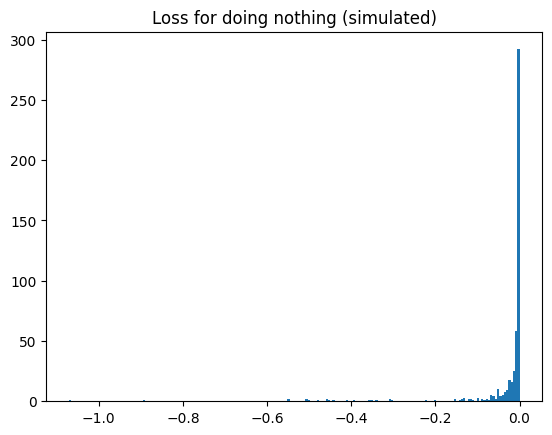

mean -0.03281656315534215
median -0.0025546176261028695


In [24]:
def null_policy(_:Observation) -> tuple[float, float]:
    return 0, 0

# test loss function
do_nothing_loss = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game(env, null_policy, (s0, s1))
    do_nothing_loss.append(rew)

plt.title("Loss for doing nothing (simulated)")
plt.hist(do_nothing_loss, bins=200)
plt.show()
print("mean", np.mean(do_nothing_loss))
print("median", np.median(do_nothing_loss))

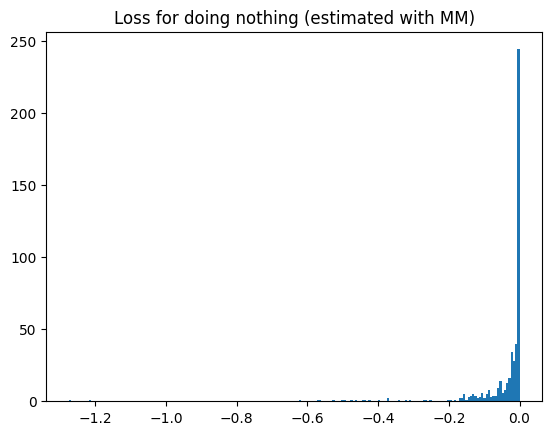

mean -0.04642388388691035
median -0.007291975021476753


In [25]:
# test loss function
do_nothing_loss_est = []
for s0, s1 in idm_test_set:
    _, rew, pred_s1 = run_game_est(mm, null_policy, (s0, s1))
    do_nothing_loss_est.append(rew)

plt.title("Loss for doing nothing (estimated with MM)")
plt.hist(do_nothing_loss_est, bins=200)
plt.show()
print("mean", np.mean(do_nothing_loss_est))
print("median", np.median(do_nothing_loss_est))

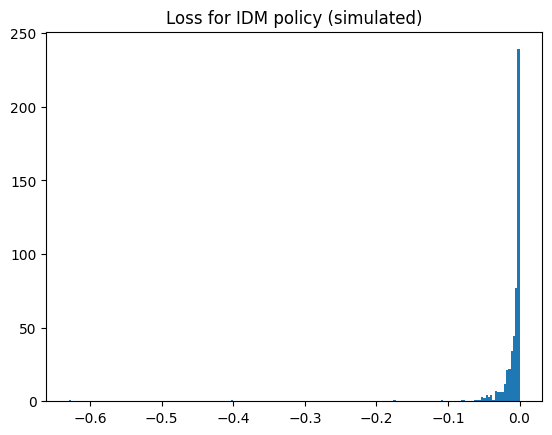

mean -0.010425357086744351
median -0.003459867868760131


In [31]:
# test loss function
idm_loss = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game(env, IDMPolicy(idm), (s0, s1))
    idm_loss.append(rew)

plt.title("Loss for IDM policy (simulated)")
plt.hist(idm_loss, bins=200)
plt.show()
print("mean", np.mean(idm_loss))
print("median", np.median(idm_loss))

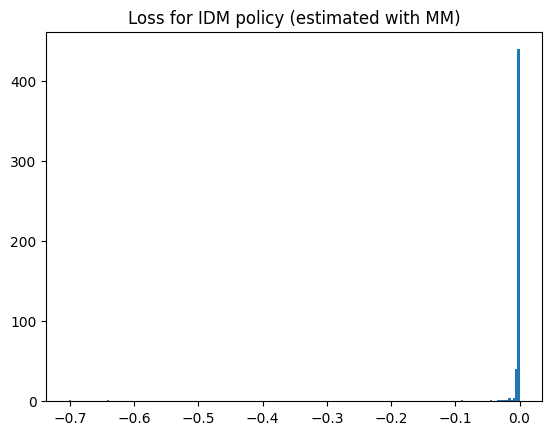

mean -0.0045199451659351355
median -0.0004388510470411805


In [32]:
# test loss function
idm_loss_est = []
for s0, s1 in idm_test_set:
    _, rew, _ = run_game_est(mm, IDMPolicy(idm), (s0, s1))
    idm_loss_est.append(rew)

plt.title("Loss for IDM policy (estimated with MM)")
plt.hist(idm_loss_est, bins=200)
plt.show()
print("mean", np.mean(idm_loss_est))
print("median", np.median(idm_loss_est))

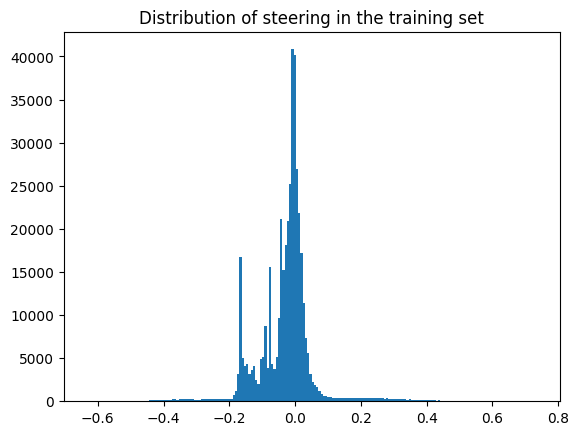

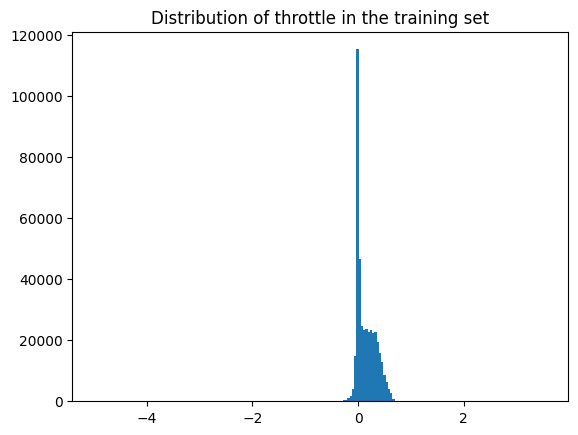

In [35]:
plt.title("Distribution of steering in the training set")
plt.hist(action_pred[:, 0].cpu().detach().numpy(), bins=200)
plt.show()

plt.title("Distribution of throttle in the training set")
plt.hist(action_pred[:, 1].cpu().detach().numpy(), bins=200)
plt.show()

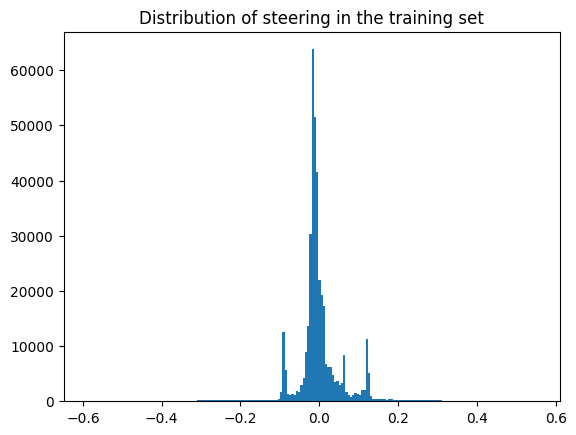

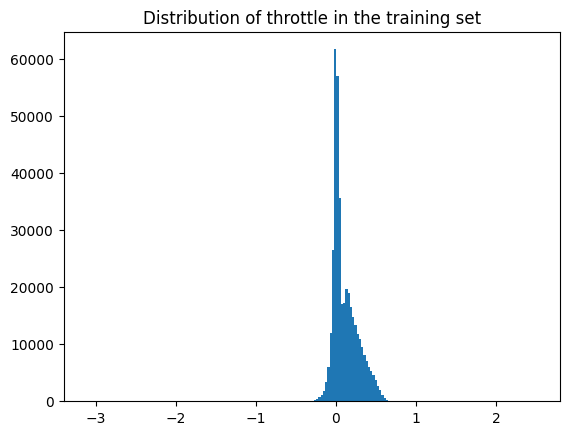

In [39]:
plt.title("Distribution of steering in the training set")
plt.hist(action_pred[:, 0].cpu().detach().numpy(), bins=200)
plt.show()

plt.title("Distribution of throttle in the training set")
plt.hist(action_pred[:, 1].cpu().detach().numpy(), bins=200)
plt.show()